<a href="https://colab.research.google.com/github/calpis10000/commonlit/blob/main/02_nb/032_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
if 'google.colab' in sys.modules:  # colab特有の処理_2回目移行
  # Google Driveのマウント
  from google.colab import drive
  drive.mount('/content/drive')

  # データセットをDriveから取得
  !mkdir -p 'input'
  !cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/00_input' '/content/input'

  # ライブラリのパス指定
  sys.path.append('/content/drive/MyDrive/Colab_Files/kaggle/commonlit/XX_modules')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
import gensim
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re
import fasttext

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

import torch
import transformers

from transformers import BertTokenizer
from tqdm import tqdm
tqdm.pandas()

In [3]:
# 試験ID生成
trial_prefix = '057-036-01-02'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

057-036-01-02
057-036-01-02_20210801_013055


In [4]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
elif 'google.colab' in sys.modules:
    OUTPUT_DIR = Path("/content/drive/MyDrive/Colab_Files/kaggle/commonlit/03_outputs")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [5]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [6]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
elif 'google.colab' in sys.modules:
    DATA_DIR = '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/00_input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [7]:
# read_data
train_base = pd.read_csv(DATA_DIR + "train_kfold.csv")
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [8]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [9]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [11]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## 前処理_品詞変換

In [12]:
# テキスト情報を品詞に変換
def get_pos_tag(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return pos_tag

def get_pos_tag_to_text(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return " ".join(pos_tag)

## テキスト特徴_シンプルなTF-IDF

In [13]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfSimpleBlock(BaseBlock):
    """シンプルなTF-IDF特徴を作成する block"""
    def __init__(self, column: str, max_features=50, ngram_range=(1,1), use_idf=True):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.max_features=max_features
        self.ngram_range=ngram_range
        self.use_idf=use_idf
        self.param_prefix=f"col={column}_max_features={max_features}_\
                              ngram={ngram_range[0]}_{ngram_range[1]}_use_idf={use_idf}"

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.vectorizer_ = TfidfVectorizer(max_features=self.max_features
                                      ,ngram_range=self.ngram_range
                                      ,use_idf=self.use_idf)

        self.vectorizer_.fit(text)
        self.prefix = 'tfidf' if self.use_idf == True else 'tf'
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.vectorizer_.transform(text)

        out_df = pd.DataFrame(z.toarray())
        out_df.columns = self.vectorizer_.get_feature_names()
        return out_df.add_prefix(f'{self.prefix}_')


In [14]:
tfidf_ = TfidfSimpleBlock('excerpt')
tfidf_.fit(train_base)

,tfidf_also,tfidf_away,tfidf_back,tfidf_called,tfidf_came,tfidf_come,tfidf_could,tfidf_day,tfidf_different,tfidf_even,tfidf_every,tfidf_first,tfidf_found,tfidf_get,tfidf_go,tfidf_good,tfidf_great,tfidf_home,tfidf_house,tfidf_know,tfidf_like,tfidf_little,tfidf_long,tfidf_made,tfidf_make,tfidf_man,tfidf_many,tfidf_may,tfidf_much,tfidf_must,tfidf_never,tfidf_new,tfidf_old,tfidf_one,tfidf_people,tfidf_said,tfidf_saw,tfidf_see,tfidf_still,tfidf_time,tfidf_two,tfidf_upon,tfidf_us,tfidf_used,tfidf_water,tfidf_way,tfidf_well,tfidf_went,tfidf_would,tfidf_years
0,0.000000,0.000000,0.000000,0.267960,0.000000,0.0000,0.000000,0.266369,0.0,0.0,0.000000,0.258236,0.293789,0.304883,0.000000,0.573436,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.310634,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.353984,0.000000,0.246306,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.000000,0.290602,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.309261,0.0,0.000000,0.000000,0.000000,0.398350,0.000000,0.000000,0.355703,0.00000,0.0,0.000000,0.000000,0.646957,0.0,0.340804,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,0.338524,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.694673,0.000000,0.000000,0.000000,0.325484,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.299064,0.000000,0.000000,0.0,0.000000,0.0,0.343371,0.0,0.000000,0.299246,0.0
3,0.000000,0.000000,0.000000,0.239189,0.714364,0.0000,0.209488,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.255932,0.23165,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.220578,0.000000,0.277281,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.315976,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.209869,0.0
4,0.000000,0.145309,0.145984,0.130388,0.000000,0.0000,0.114197,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.156448,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.153168,0.000000,0.832858,0.086123,0.136088,0.000000,0.307613,0.00000,0.0,0.228672,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.114405,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,0.000000,0.000000,0.000000,0.000000,0.000000,0.3435,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.364012,0.000000,0.0,0.278191,0.263973,0.000000,0.283983,0.324306,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.566116,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.310038,0.0,0.000000,0.000000,0.0
2829,0.000000,0.000000,0.000000,0.445422,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.479873,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.499631,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.411033,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.390822,0.0
2830,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.312231,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.405621,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.413272,0.000000,0.0,0.000000,0.0,0.418783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.328975,0.382430,0.0,0.000000,0.0,0.000000,0.0,0.370586,0.000000,0.0
2831,0.000000,0.000000,0.000000,0.000000,0.00

## テキスト特徴_学習済みモデル（gemsim経由）

In [15]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1
# 参考: https://github.com/yagays/swem

class GensimPreTrainedBlock(BaseBlock):
    """
    文書をgemsim経由で学習済みモデルのベクトル表現へ変換するblock
    モデルは別途入手し、インスタンス作成時に指定する。
    モデル名は手動で入力する想定（デフォルトではgensim_pretrained で入る）
    """
    def __init__(self,
                 column: str,
                 model:KeyedVectors,
                 model_name='gensim_pretrained',
                 swem='aver'):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model = model
        self.model_name = model_name
        self.swem = swem # TODO:例外処理['aver', 'max', 'concat', 'hier']
        self.param_prefix= f"col={column}_model_name={model_name}_swem={swem}"

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        
        if self.swem == 'aver':
            feat = text.map(lambda x: self.average_pooling(x))
        elif self.swem == 'max': 
            feat = text.map(lambda x: self.max_pooling(x))
        elif self.swem == 'concat': 
            feat = text.map(lambda x: self.concat_average_max_pooling(x))
        elif self.swem == 'hier': 
            feat = text.map(lambda x: self.hierarchical_pooling(x, n=3))
            
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'{self.model_name}_{self.column}_{self.swem}')
    
    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
    
    # 文書ベクトルの取得
    def get_sentence_vector(self, x: str):
        ndim = self.model.vector_size
        embeddings = [
            self.model[word]
            if word in self.model
            else np.zeros(ndim)
            for word in x.split()
        ]

        if len(embeddings) == 0:
            return np.zeros(ndim, dtype=np.float32)
        else:
            return embeddings
    
    # SWEMの各処理
    def average_pooling(self, text):
        word_embeddings = self.get_sentence_vector(text)
        return np.mean(word_embeddings, axis=0)

    def max_pooling(self, text):
        word_embeddings = self.get_sentence_vector(text)
        return np.max(word_embeddings, axis=0)

    def concat_average_max_pooling(self, text):
        word_embeddings = self.get_sentence_vector(text)
        return np.r_[np.mean(word_embeddings, axis=0), np.max(word_embeddings, axis=0)]

    def hierarchical_pooling(self, text, n):
        word_embeddings = self.get_sentence_vector(text)

        text_len = len(word_embeddings) # TODO: これで合ってるか要確認
        if n > text_len:
            raise ValueError(f"window size must be less than text length / window_size:{n} text_length:{text_len}")
        window_average_pooling_vec = [np.mean(word_embeddings[i:i + n], axis=0) for i in range(text_len - n + 1)]

        return np.max(window_average_pooling_vec, axis=0)    
            


## テキスト特徴_fasttest

In [16]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1
class FasttextBlock(BaseBlock):
    """文書をfasttextのテキスト表現へ変換する block"""
    def __init__(self, column: str, ft_model:fasttext.FastText._FastText):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.ft_model = ft_model
        self.param_prefix= f"col={column}"

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: ft_model.get_sentence_vector(x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'fasttext_{self.column}_')

## テキスト特徴_統計量

In [17]:
class TextDescriptionBlock(BaseBlock):
    """テキストに関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.param_prefix = f'col={column}'

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        # 前処理
        self.text = self.preprocess(input_df)
        self.counters = self.text.map(get_counter)

        # 変換処理
        _length = input_df[self.column].fillna('').map(lambda x: len(x) if x!='' else np.nan)
        _wrd_cnt = self.counters.map(lambda x: sum(x.values()))
        _wrd_nuniq = self.counters.map(lambda x: len(x))
        _wrd_mean = self.counters.map(lambda x: np.mean(list(x.values())))
        _wrd_max = self.counters.map(lambda x: np.max(list(x.values())))
        
        word_length = self.counters.map(lambda x: np.array([len(i) for i in x.keys()]))
        word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
        _word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]
        _word_length_desc_df = _word_length_desc_df.add_prefix('word_length_')
        
        out_df = pd.concat([_length, _wrd_cnt, _wrd_nuniq, _wrd_mean, _wrd_max], axis=1)
        out_df.columns = ['text_length', 'word_count', 'word_nunique', 'word_appearance_mean', 'word_appearance_max']
        out_df = pd.concat([out_df, _word_length_desc_df], axis=1)
        return out_df.add_suffix(f'_{self.column}')

## テキスト特徴_CountVectorizer

In [18]:
class CountVectorizerBlock(BaseBlock):
    """CountVectorizer x SVD による圧縮を行なう block"""
    def __init__(self, column: str, master_df=None, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.master_df=master_df
        self.n_components=n_components
        self.ngram_range=ngram_range
        self.param_prefix = f"col={column}_comp={n_components}_ngram={''.join([str(i) for i in self.ngram_range])}"

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def fit(self, 
            input_df, 
            y=None
           ):
        master_df = input_df if self.master_df is None else self.master_df
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', CountVectorizer(ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'countvect_{self.column}_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_TF-IDF

In [19]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, master_df=None, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.master_df=master_df
        self.n_components=n_components
        self.ngram_range=ngram_range
        self.param_prefix = f"col={column}_comp={n_components}_ngram={''.join([str(i) for i in self.ngram_range])}"

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def fit(self, 
            input_df, 
            y=None
           ):
        master_df = input_df if self.master_df is None else self.master_df
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000, ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'tfidf_{self.column}_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_W2V(データセットから学習)

In [20]:
# https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

class W2VTrainBlock(BaseBlock):
    """Word2Vecを学習し、文書のベクトル表現を得るブロック。
       学習済みモデルを使うパターンは、別に作成するものとする。"""
    def __init__(self, 
                 column: str, 
                 master_df=None,
                 model_size=50, 
                 min_count=1, 
                 window=5,
                 n_iter=100
                 ):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.master_df = master_df
        self.model_size = model_size
        self.min_count = min_count
        self.window = window
        self.n_iter = n_iter
        self.param_prefix = f"col={column}_model_size={model_size}_min_count={min_count}_window={window}_n_iter={n_iter}"

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def fit(self, 
            input_df, 
            y=None
           ):
        master_df = input_df if self.master_df is None else self.master_df
        text = self.preprocess(master_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])
        self.w2v_model = word2vec.Word2Vec(word_lists.values.tolist(),
                                      vector_size=self.model_size,
                                      min_count=self.min_count,
                                      window=self.window,
                                      seed=SEED,
                                      workers=1,
                                      hashfxn=hashfxn,
                                      epochs=self.n_iter)

        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = word_lists.progress_apply(
            lambda x: np.mean([self.w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"w2v_{self.column}_w{self.window}_{i}"
                                                   for i in range(self.model_size)])
        
        return sentence_vector_df


In [21]:
# 使用モデル指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    _bert_model_name = '../input/huggingface-bert-variants/bert-base-cased/bert-base-cased/'
else: # ローカル or Colab
    _bert_model_name = 'bert-base-cased'

# 学習済みBERT
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' # cudaが無いならcpuを使えばいいじゃない
        self.model_name = _bert_model_name # 学習済みモデルの名前を指定
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name) # 指定したmodel_nameでtokenizerを作成
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name) # 指定したmodel_nameで学習済みmodelを作成
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 176

    def get_imp(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)
        return [inp, len_inp]

    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()


In [22]:
from transformers import RobertaTokenizer, RobertaModel

# 使用モデル指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    _roberta_model_name = '../input/roberta-base/'
else: # ローカル or Colab
    _roberta_model_name = 'roberta-base'

# 学習済みRoBerta
class RoBertaSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' # cudaが無いならcpuを使えばいいじゃない
        self.model_name = _roberta_model_name # 学習済みモデルの名前を指定
        self.tokenizer = RobertaTokenizer.from_pretrained(self.model_name) # 指定したmodel_nameでtokenizerを作成
        self.bert_model = transformers.RobertaModel.from_pretrained(self.model_name) # 指定したmodel_nameで学習済みmodelを作成
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 176

    def get_imp(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)
        return [inp, len_inp]

    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()


In [23]:
class BERTPreTrainedBlock(BaseBlock):
    """
    学習済みBERTモデルを用いて、文書をベクトル表現へ変換するblock
    """
    def __init__(self,
                 column: str,
                 model=BertSequenceVectorizer(),
                 model_name='bert-base-cased'
                ):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model = model
        self.model_name = model_name
        self.param_prefix = f"col={column}_model_name={model_name}"

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):            
        bert_out = input_df[self.column].progress_apply(lambda x: self.model.vectorize(x))
        out_df = pd.DataFrame(np.stack(bert_out))
        return out_df.add_prefix(f'{self.model_name}_{self.column}')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# make_feat

In [24]:
# 特徴量の出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    FEAT_DIR = Path("../input/clrp-myfeat") # 事前作成したデータセットを指定。出力先というより、読込元として指定している。
elif 'google.colab' in sys.modules:
    FEAT_DIR = Path('/content/drive/MyDrive/Colab_Files/kaggle/commonlit/04_feature/057_')
else:
    FEAT_DIR = Path(f"../04_feature")
    FEAT_DIR.mkdir(exist_ok=True, parents=True)

In [25]:
import gensim.downloader as api

# モデル入手
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    fast_path = '../input/fasttext-pretrained-crawl-vector-en-bin/cc.en.300.bin'
    gen_glv_wiki_path = '../input/stanfords-glove-pretrained-word-vectors/glove.6B.300d.txt'
    gen_glv_twi_path = '../input/glovetwitter27b-in-gensim-kv-format/glove.twitter.27B.200d.kv'
    gen_ggl_path = '../input/gensim-google-data/GoogleNews-vectors-negative300.bin'

    ft_model = fasttext.load_model(fast_path)
    gen_glv_wiki_model = KeyedVectors.load_word2vec_format(gen_glv_wiki_path, binary=False)
    #gen_glv_twi_model = KeyedVectors.load(gen_glv_twi_path)
    #gen_ggl_model = KeyedVectors.load_word2vec_format(gen_ggl_path, binary=True)

elif 'google.colab' in sys.modules:
    fast_path = '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/97_pre_trained/cc.en.300.bin'
    gen_glv_wiki_model = api.load('glove-wiki-gigaword-300')
    ft_model = fasttext.load_model(fast_path)

else: # ローカルまたは自前のクラウド環境を想定
    fast_path = '../97_pre_trained/cc.en.300.bin'
    gen_glv_wiki_path = '~/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300'
    gen_glv_twi_path = '~/gensim-data/glove-twitter-200/glove-twitter-200.gz'
    gen_ggl_path = '~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'

    ft_model = fasttext.load_model('../97_pre_trained/cc.en.300.bin') # fasttext重いので、gensim実装のやつ無いかなあ
    gen_glv_wiki_model = KeyedVectors.load_word2vec_format(gen_glv_wiki_path, binary=False)
    #gen_glv_twi_model = KeyedVectors.load_word2vec_format(gen_glv_twi_path, binary=False)
    #gen_ggl_model = KeyedVectors.load_word2vec_format(gen_ggl_path, binary=True)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [26]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = pd.concat([train_base[['id', 'excerpt']], test_base[['id', 'excerpt']]], axis='rows')

In [27]:
# 特徴量の出力
import feather 
def save_feather(input_df:pd.DataFrame, filename_:str):
    input_df.to_feather(FEAT_DIR/filename_)
    
def load_feather(filename_:str):
    return pd.read_feather(FEAT_DIR/filename_)

def save_pickle(obj, filename_:str):
    with open(FEAT_DIR/filename_, 'wb') as f:
        pickle.dump(obj, f)
    
def load_pickle(filename_:str):
    with open(FEAT_DIR/filename_, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [28]:
# https://www.guruguru.science/competitions/16/discussions/95b7f8ec-a741-444f-933a-94c33b9e66be/
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py

from time import time

# 文字列を「*」で囲っていい感じに見せる関数？
def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

# 時間計測用
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time() 
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [29]:
# 一旦これで進めるが、もうちょっとスマートにしたい。
def run_blocks(input_df, blocks, y=None, test=False, save_feat=True):
    out_df = pd.DataFrame()

    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)): 
        for block in blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                name = block.__class__.__name__
                params = block.param_prefix
                filename_df = f"{'Test' if test else 'Train'}_{name}_{params}.ftr"
                filepath_df = FEAT_DIR/filename_df

                if filepath_df.exists():
                    out_i = pd.read_feather(filepath_df)
                    print(f'skip -> read:{filename_df}')
                else:
                    if not test:
                        out_i = block.fit(input_df, y=y)
                    else:
                        out_i = block.transform(input_df)

                if save_feat:
                    save_feather(out_i, filename_df)

                assert len(input_df) == len(out_i)
                out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)
    return out_df

In [30]:
type(FEAT_DIR)

pathlib.PosixPath

In [31]:
# 特徴作成: 実行
feat_blocks = [TextDescriptionBlock('excerpt')
              ,TfidfBlock('excerpt', master_df=whole_df, ngram_range=(1,1))
              #,TfidfBlock('excerpt', master_df=whole_df, ngram_range=(2,2))
              #,TfidfBlock('excerpt', master_df=whole_df, ngram_range=(1,2))
              ,FasttextBlock('excerpt', ft_model)
              #,W2VTrainBlock('excerpt', master_df=whole_df, window=3)
              #,W2VTrainBlock('excerpt', master_df=whole_df, window=10)
              #,W2VTrainBlock('excerpt', master_df=whole_df, window=100)
              ,GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='aver')
             ,BERTPreTrainedBlock('excerpt')
             ,BERTPreTrainedBlock('excerpt', model=RoBertaSequenceVectorizer(), model_name='roberta-base')
              ]

train_feat = run_blocks(train_base, feat_blocks, save_feat=False)
test_feat = run_blocks(test_base, feat_blocks, test=True, save_feat=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.TextDescriptionBlock object at 0x7f3fe3b77510> 6.710[s]
	- <__main__.TfidfBlock object at 0x7f3fe3b77590> 2.699[s]
	- <__main__.FasttextBlock object at 0x7f3fe3b775d0> 1.934[s]


  0%|          | 0/2833 [00:00<?, ?it/s]

	- <__main__.GensimPreTrainedBlock object at 0x7f3fe3b77650> 1.448[s]


  0%|          | 0/2833 [00:00<?, ?it/s]

	- <__main__.BERTPreTrainedBlock object at 0x7f3fe3b77690> 2025.498[s]


  0%|          | 0/7 [00:00<?, ?it/s]

	- <__main__.BERTPreTrainedBlock object at 0x7f3fe2c23490> 1933.972[s]
run test=False 3972.265[s]
★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.TextDescriptionBlock object at 0x7f3fe3b77510> 0.046[s]
	- <__main__.TfidfBlock object at 0x7f3fe3b77590> 0.018[s]
	- <__main__.FasttextBlock object at 0x7f3fe3b775d0> 0.019[s]
	- <__main__.GensimPreTrainedBlock object at 0x7f3fe3b77650> 0.014[s]


  0%|          | 0/7 [00:00<?, ?it/s]

	- <__main__.BERTPreTrainedBlock object at 0x7f3fe3b77690> 4.573[s]


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

	- <__main__.BERTPreTrainedBlock object at 0x7f3fe2c23490> 4.844[s]
run test=True 9.517[s]


In [32]:
print(train_feat.shape)
print(test_feat.shape)

(2833, 2198)
(7, 2198)


## Train & Predict

In [33]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [34]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [35]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [36]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge


In [38]:
oof_preds = np.zeros(len(train_base))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for fold in sorted(train_base['kfold'].unique()):
    print(f'\nFold {fold + 1}')
    train_indices = (train_base['kfold'] != fold).index
    val_indices = (train_base['kfold'] == fold).index

    trn_x, trn_y = train_feat.iloc[train_indices], train_target.iloc[train_indices]
    val_x, val_y = train_feat.iloc[val_indices], train_target.iloc[val_indices]
    
    model = BayesianRidge(n_iter=300, verbose=True)
    model.fit(
        X=trn_x,
        y=trn_y
    )
    
    val_preds = model.predict(val_x)
    oof_preds[val_indices] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = np.sqrt(mean_squared_error(val_y, val_preds))
    scores.append(val_score)
    models.append(model)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
Convergence after  19  iterations

Fold 2
Convergence after  19  iterations

Fold 3
Convergence after  19  iterations

Fold 4
Convergence after  19  iterations

Fold 5
Convergence after  19  iterations
Mean RMSE: 0.45553090576230587, std: 0.0, All RMSE: 0.45553090576230587


In [39]:
oof_preds

array([-0.25976037, -0.50063609, -1.48852103, ..., -2.32405182,
       -2.18387079, -0.16161067])

In [40]:
from sklearn.metrics import mean_squared_error
import math
np.sqrt(mean_squared_error(train_base.target.values, oof_preds))

0.45553090576230587

In [41]:
train_base['pred'] = oof_preds
fold = 4
tg_true = train_base[train_base['kfold']==fold]['target'].values
tg_pred = train_base[train_base['kfold']==fold]['pred'].values
np.sqrt(mean_squared_error(tg_true, tg_pred))

0.4551632967859288

In [42]:
train_base['diff_sq'] = (train_base['target'] - train_base['pred'])**2

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


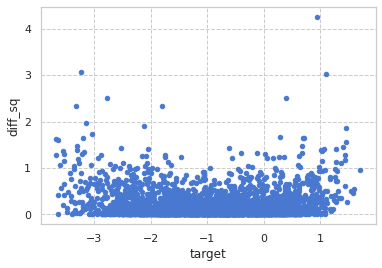

In [43]:
%matplotlib inline
train_base.plot(kind='scatter', x='target', y='diff_sq')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


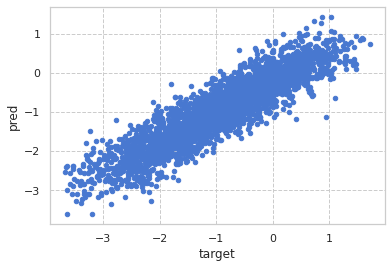

In [46]:
train_base.plot(kind='scatter', x='target', y='pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fd4fe3990>]],
      dtype=object)

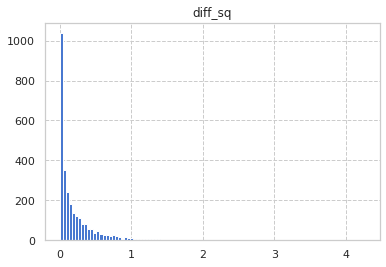

In [56]:
%matplotlib inline
train_base[['diff_sq']].hist(bins=100)